### Import the necessary libraries

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from scipy.signal import butter, filtfilt

from scipy.stats import skew, kurtosis

from scipy.signal import welch

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

### Read the datasets

In [2]:
df = pd.read_csv('./datasets/imu_data.csv')

In [3]:
df.head()

,accelerometer,gyro,surface
0,0.903738,1.698736,asphalt
1,0.834571,2.051725,asphalt
2,1.160288,0.895211,asphalt
3,1.106549,1.276459,asphalt
4,0.931808,4.475666,asphalt


### Pre-Processing

#### Filtering
As seen in the exploratory data analysis, the IMU acceleration data captured from the rollator movement includes both the high-frequency acceleration due to movement and the low-frequeny acceleration due to gravity. To accurately classify surfaces based on the rollator's movement, it's crucial to eliminate the noise introduced by gravitational acceleration.

We will employ a high-pass Butterworth filter to achive this.

In [4]:
#Getting subsets of the dataframe df for each surfaces.

asphalt_df = df[df['surface'] == 'asphalt'].reset_index(drop = True)

concrete_df = df[df['surface'] == 'concrete'].reset_index(drop = True)

grass_df = df[df['surface'] == 'grass'].reset_index(drop = True)

stone_df = df[df['surface'] == 'stones'].reset_index(drop = True)

tile_df = df[df['surface'] == 'tile'].reset_index(drop = True)

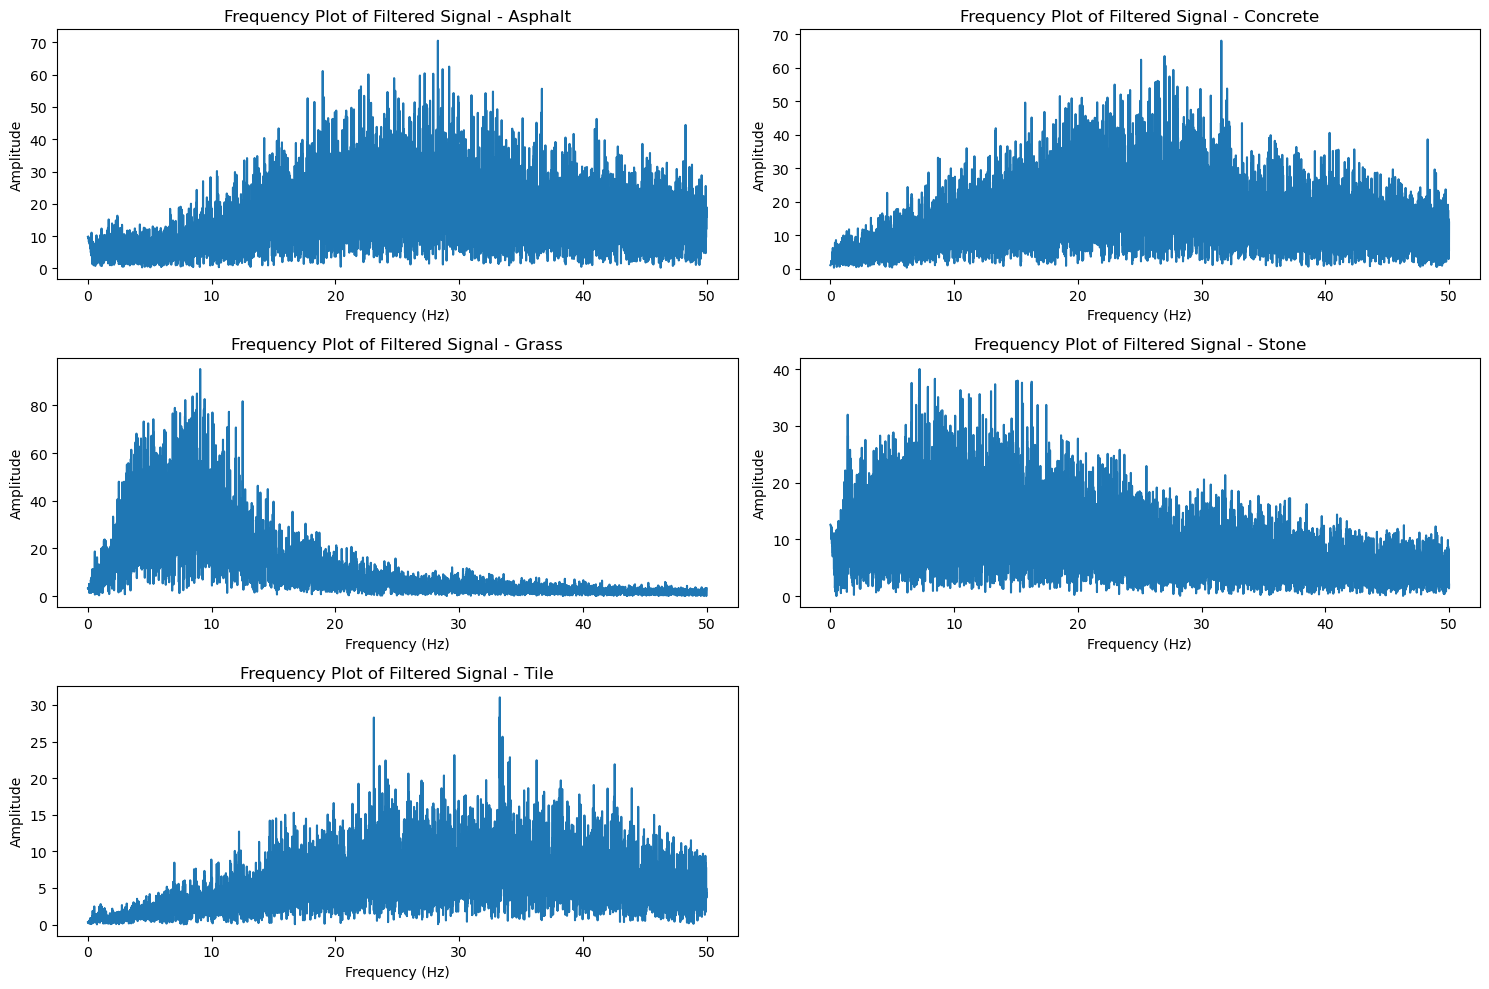

In [5]:
# Set the sampling frequency in Hz

fs = 100 

# Set the cutoff frequency for the high-pass filter

cutoff = 0.25

# Design a high-pass Butterworth filter with order 1

b, a = butter(N = 1, Wn = cutoff / (0.5*fs), btype = 'high', analog=False)

# List of dataframes, each representing different surfaces

dataframe_list = [asphalt_df, concrete_df, grass_df, stone_df, tile_df]

# Corresponding names of the surfaces

names_list = ['Asphalt', 'Concrete', 'Grass', 'Stone', 'Tile']

# Create a figure with specific dimensions

plt.figure(figsize = (15, 10))

# Loop through each dataframe and its corresponding name

for index, (df, name) in enumerate(zip(dataframe_list, names_list)):

    # Apply the high-pass filter to the accelerometer data

    df['filtered accelerometer'] = filtfilt(b, a, df['accelerometer'])

    # Compute the Fast Fourier Transform (FFT) of the filtered signal

    fft_result_filtered = np.fft.fft(df['filtered accelerometer'])

    # Calculate frequency bins for the FFT result

    fft_freq_filtered = np.fft.fftfreq(len(df['filtered accelerometer']), 1/fs)

    # Filter to retain only positive frequencies

    positive_freqs = fft_freq_filtered > 0

    # Plot the filtered signal in a subplot within a 3x2 grid

    plt.subplot(3, 2, index + 1)

    # Plot the magnitude of FFT results against frequencies
    
    plt.plot(fft_freq_filtered[positive_freqs], np.abs(fft_result_filtered[positive_freqs]))

    # Set the title indicating the surface and filtered signal
    
    plt.title(f'Frequency Plot of Filtered Signal - {name}')

    # Label the x-axis with frequency in Hertz
    
    plt.xlabel('Frequency (Hz)')

    # Label the y-axis with amplitude
    
    plt.ylabel('Amplitude')

# Adjust the layout

plt.tight_layout()

# Display the plots

plt.show()

From the Frequency domain plot, the high amplitudes at the very low frequency (0 Hz) has been reduced, indicating a decrease in the impact of gravitational acceleration.

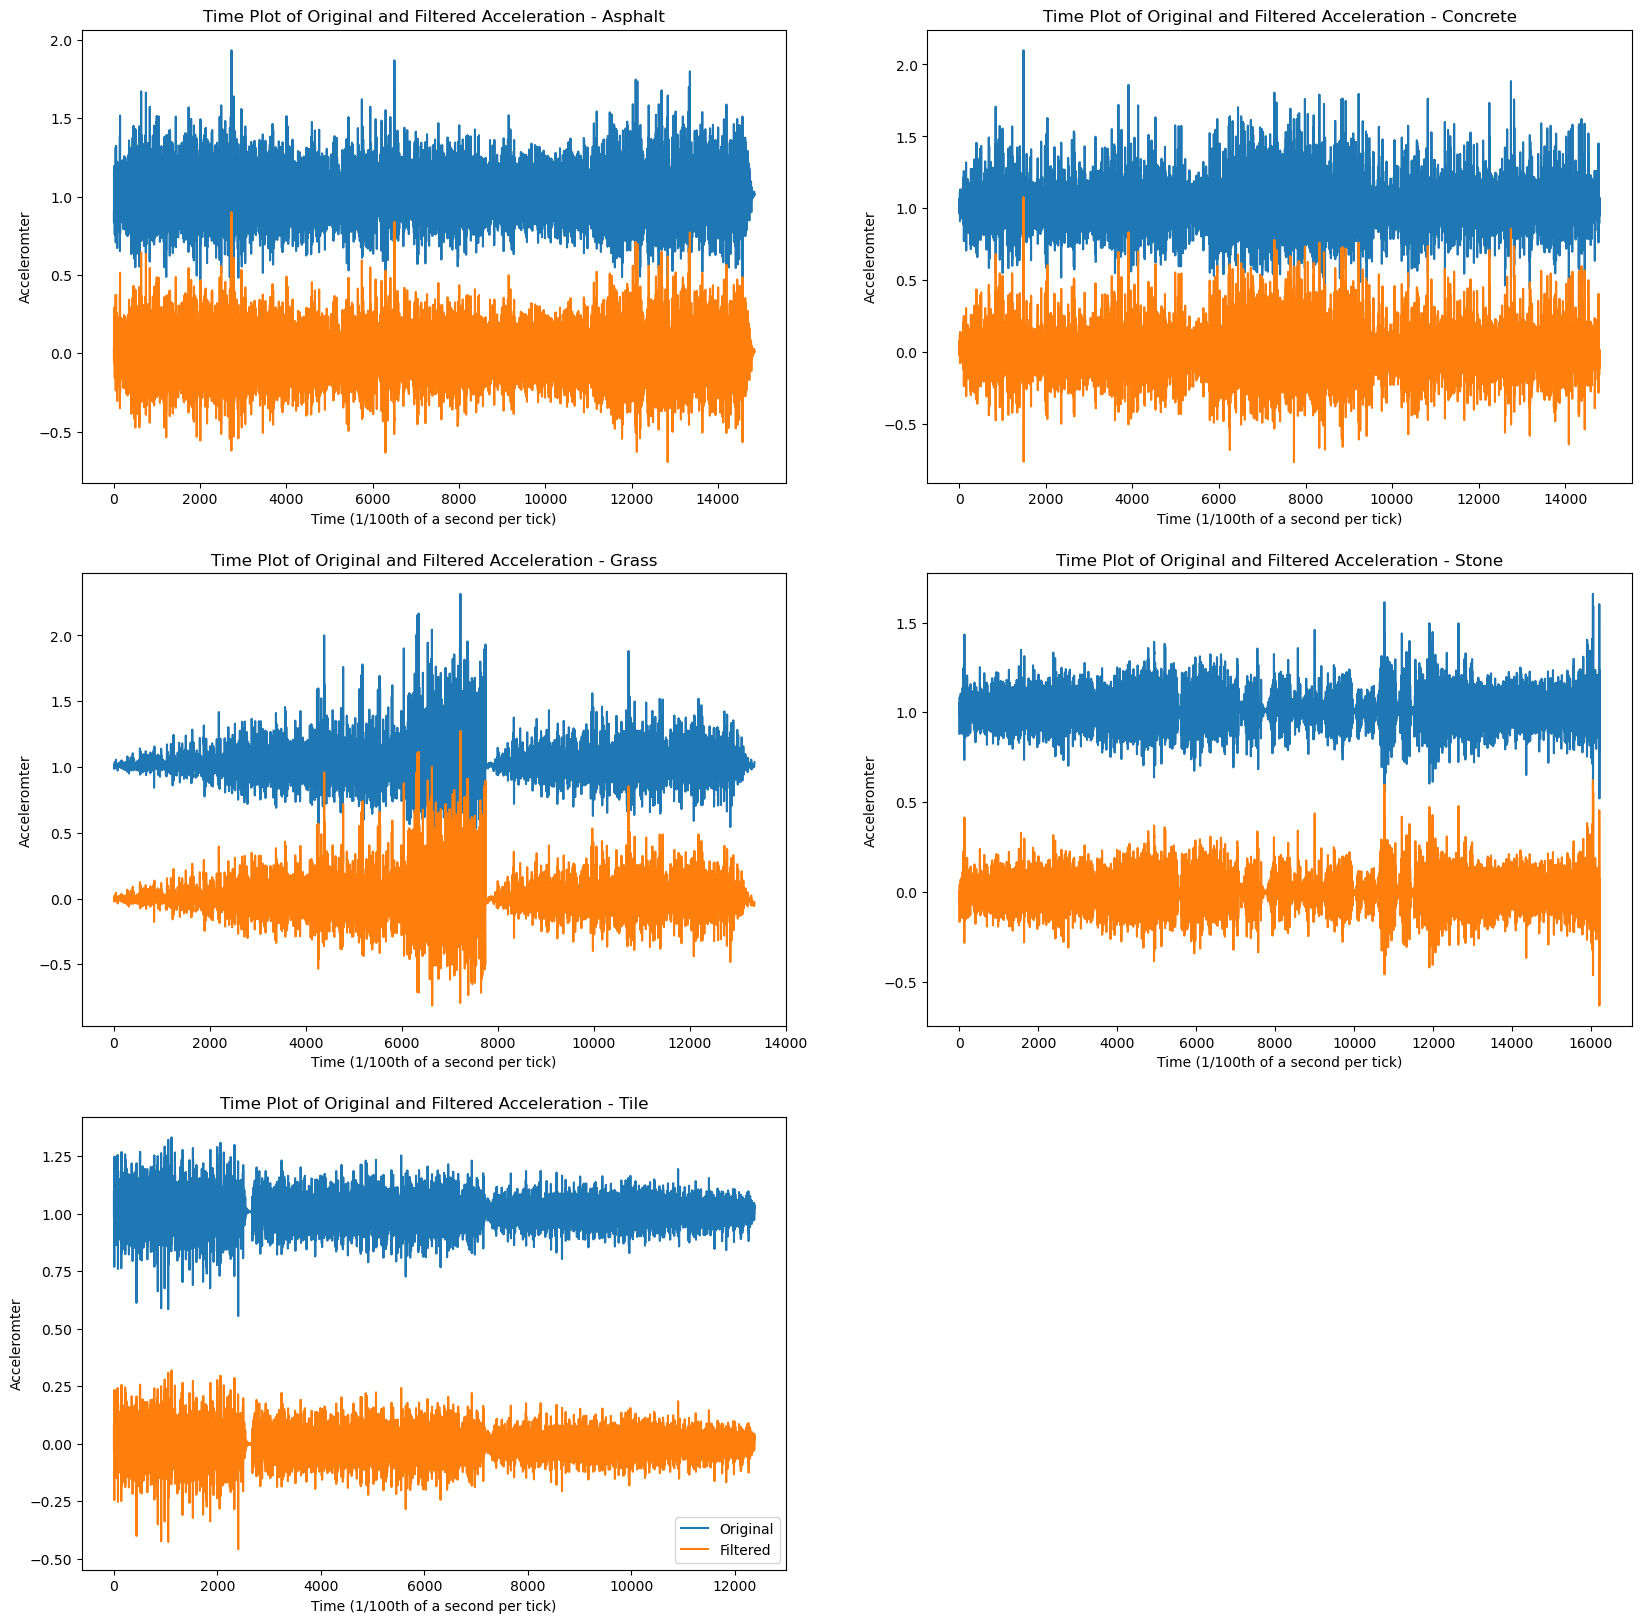

In [6]:
# Create a figure with specific dimensions

plt.figure(figsize = (20, 20))

# Loop through each dataframe and corresponding surface name

for index, (df, name) in enumerate(zip(dataframe_list, names_list)):

    # Create a subplot in a 3x2 grid for each pair of data

    plt.subplot(3, 2, index + 1)

    # Plot the original accelerometer data

    plt.plot(df['accelerometer'], label = 'Original')

    # Plot the filtered accelerometer data

    plt. plot(df['filtered accelerometer'], label = 'Filtered')

    # Set the title of each subplot to indicate it shows both original and filtered data for the surface

    plt.title(f'Time Plot of Original and Filtered Acceleration - {name}')

     # Label the x-axis 

    plt.xlabel('Time (1/100th of a second per tick)')

    # Label the y-axis

    plt.ylabel('Acceleromter')

# Add a legend

plt.legend()

# Display plots

plt.show()

The time plots comparing the original and filtered acceleration shows that the filtered acceleration consistently trends below the original. This indicates a reduction or removal of the gravitational acceleration. However, the overall pattern of both the original and filtered accelerations remains unchanged.

### Clustering

As part of the preprocessing, we will employ clustering.

This involves using the sliding window technique to partition data into windows based on a defined window size. Features extracted from each window will serve as input for the clustering algorithm. To ensure effective clustering, windows will not overlap across different surfaces, and any windows that do not meet the specififed size will be discarded.

In [7]:
# Concatenate dataframes from different surface types into a single dataframe along rows

df2 = pd.concat([asphalt_df, concrete_df, grass_df, stone_df, tile_df], axis = 0 )

# Remove the 'accelerometer' column from the dataframe

df2 = df2.drop(['accelerometer'], axis = 1)

# Reorder the columns

df2 = df2.iloc[:, [2,0,1]]

# Reset the index of the dataframe

df2 = df2.reset_index(drop = True)

# Display the first five rows

df2.head()

,filtered accelerometer,gyro,surface
0,0.028466,1.698736,asphalt
1,-0.042912,2.051725,asphalt
2,0.280607,0.895211,asphalt
3,0.224717,1.276459,asphalt
4,0.047872,4.475666,asphalt


In [8]:
df2.to_csv('./datasets/imu_data_filtered.csv', index = False)

### Sliding Window

In [9]:
# Function to partition a dataframe `df` into windows of `window_size` based on the 'surface' attribute.

def sliding_window(df, window_size):
    
    groups = []
    
    current_group = []
    
    current_surface = None  

    for index, row in df.iterrows():
        
        if current_surface is None:
            
            current_surface = row['surface']  

        if row['surface'] == current_surface:
            
            current_group.append((row['filtered accelerometer'], row['gyro']))

            if len(current_group) == window_size:
                
                groups.append((current_group, current_surface)) 
                
                current_group = [] 

        else:
            
            if len(current_group) == window_size:
                
                groups.append((current_group, current_surface))

            current_group = [(row['filtered accelerometer'], row['gyro'])]
            
            current_surface = row['surface']
            
    if len(current_group) == window_size:
        
        groups.append((current_group, current_surface))

    return groups

### Feature Extraction

In [10]:
# Sets of functions for the features to be extracted from each window

def calculate_mean(data):

    # Calculate mean of the accelerometer data in the window
    
    accelerometer_mean = np.mean([x[0] for x in data[0]])

    # Calculate mean of the gyro data in the window
    
    gyro_mean = np.mean([x[1] for x in data[0]])
    
    return accelerometer_mean, gyro_mean

def calculate_std(data):

    # Calculate standard deviation of the accelerometer data in the window
    
    accelerometer_std = np.std([x[0] for x in data[0]]) 

    # Calculate standard deviation of the gyro data in the window
    
    gyro_std = np.std([x[1] for x in data[0]])
    
    return accelerometer_std, gyro_std

def calculate_max(data):

    # Get the maximum of the accelerometer data in the window
    
    accelerometer_max = np.max([x[0] for x in data[0]]) 

    # Get the maximum of the gyro data in the window
    
    gyro_max = np.max([x[1] for x in data[0]]) 
    
    return accelerometer_max, gyro_max

def calculate_min(data):

    # Get the minimum of the accelerometer data in the window
    
    accelerometer_min = np.min([x[0] for x in data[0]])

    # Get the minimum of the gyro data in the window
    
    gyro_min = np.min([x[1] for x in data[0]])
    
    return accelerometer_min, gyro_min

def calculate_iqr(data):

    # Calculate IQR of the accelerometer data in the window
    
    accelerometer_iqr = np.percentile([x[0] for x in data[0]], 75) - np.percentile([x[0] for x in data[0]], 25)

    # Calculate IQR of the gyro data in the window
    
    gyro_iqr = np.percentile([x[1] for x in data[0]], 75) - np.percentile([x[1] for x in data[0]], 25) 
    
    return accelerometer_iqr, gyro_iqr

def calculate_skewness(data):

    # Calculate the skewness of the accelerometer data in the window
    
    accelerometer_skew = skew([x[0] for x in data[0]])

    # Calculate the skewness of the gyro data in the window
    
    gyro_skew = skew([x[1] for x in data[0]])
    
    return accelerometer_skew, gyro_skew

def calculate_kurtosis(data):

    # Calculate the kurtosis of the accelerometer data in the window
    
    accelerometer_kurt = kurtosis([x[0] for x in data[0]])

    # Calculate the kurtosis of the gyro data in the window
    
    gyro_kurt = kurtosis([x[1] for x in data[0]])
    
    return accelerometer_kurt, gyro_kurt
    
def calculate_fft_peak(data, sampling_rate):
    
    # Compute the FFT of the accelerometer data
    
    fft_acc = np.fft.fft([x[0] for x in data[0]])

    # Compute the FFT of the gyro data
    
    fft_gyro = np.fft.fft([x[1] for x in data[0]])

    # Calculate the magnitude spectrum of the accelerometer FFT
    
    mag_acc = np.abs(fft_acc)

    # Calculate the magnitude spectrum of the gyro FFT
    
    mag_gyro = np.abs(fft_gyro)

    # Find the index of the peak in the accelerometer magnitude spectrum
    
    peak_index_acc = np.argmax(mag_acc)

    # Find the index of the peak in the gyroscope magnitude spectrum
    
    peak_index_gyro = np.argmax(mag_gyro)

    # Get the peak amplitude for the accelerometer
    
    peak_amplitude_acc = mag_acc[peak_index_acc]

    # Get the peak amplitude for the gyro
    
    peak_amplitude_gyro = mag_gyro[peak_index_gyro]

    # Generate frequency values corresponding to the FFT results

    freqs = np.fft.fftfreq(len(fft_acc), d = 1/sampling_rate)

    # Calculate the peak frequency for the accelerometer

    peak_frequency_acc = np.abs(freqs[peak_index_acc])
    
    return peak_amplitude_acc, peak_frequency_acc, peak_amplitude_gyro

def calculate_psd(data):

    # Extract accelerometer data and convert to numpy array
    
    accelerometer_data = np.array([x[0] for x in data[0]])

    # Extract gyro data and convert to numpy array
    
    gyro_data = np.array([x[1] for x in data[0]])

    # Calculate the Power Spectral Density (PSD) for accelerometer data

    f_acc, psd_acc = welch(accelerometer_data, fs=100, nperseg=100)

    # Calculate the Power Spectral Density (PSD) for gyro data
    
    f_gyro, psd_gyro = welch(gyro_data, fs=100, nperseg=100)

    # Identify the frequency of the peak in the accelerometer PSD

    peak_freq_acc = f_acc[np.argmax(psd_acc)]

    # Identify the peak power in the accelerometer PSD
    
    peak_power_acc = np.max(psd_acc)
    
    # Identify the frequency of the peak in the gyro PSD
    
    peak_freq_gyro = f_gyro[np.argmax(psd_gyro)]

    # Identify the peak power in the gyro PSD
    
    peak_power_gyro = np.max(psd_gyro)

    # Convert the peak power from power to decibels (dB) for the accelerometer

    peak_power_acc_db = 10*np.log10(peak_power_acc)

    # Convert the peak power from power to decibels (dB) for the gyro

    peak_power_gyro_db = 10*np.log10(peak_power_gyro)

    return peak_freq_acc, peak_power_acc_db, peak_freq_gyro, peak_power_gyro_db

def extract_surface(data):

    # Extract the Surface for the window

    surface = data[1] 

    return surface

In [11]:
### function that append to an empty list a dictionary of name of features, features value key value 

def extract_features(segments):
    
    features_list = []
    
    for segment in segments:

        psd_features = calculate_psd(segment)
        
        features = {
            'accelerometer_mean': calculate_mean(segment)[0],
            'accelerometer_std': calculate_std(segment)[0],
            'accelerometer_min': calculate_min(segment)[0],
            'accelerometer_max': calculate_max(segment)[0],
            'accelerometer_iqr': calculate_iqr(segment)[0],
            'accelerometer_skewness': calculate_skewness(segment)[0],
            'accelerometer_kurtosis': calculate_kurtosis(segment)[0],
            'accelerometer_fft_peak_amplitude': calculate_fft_peak(segment, 100)[0],
            'accelerometer_fft_peak_frequency': calculate_fft_peak(segment, 100)[1],
            'accelerometer_peak_power': psd_features[1],
            'accelerometer_peak_freq': psd_features[0],
            'gyro_mean': calculate_mean(segment)[1],
            'gyro_std': calculate_std(segment)[1],
            'gyro_min': calculate_min(segment)[1],
            'gyro_max': calculate_max(segment)[1],
            'gyro_iqr': calculate_iqr(segment)[1],
            'gyro_skewness': calculate_skewness(segment)[1],
            'gyro_kurtosis': calculate_kurtosis(segment)[1],
            'gyro_fft_peak_amplitude': calculate_fft_peak(segment, 100)[2],
            'gyro_peak_power': psd_features[3],
            'gyro_peak_freq': psd_features[2],
            'surface': extract_surface(segment)
        }
        features_list.append(features)
    
    return features_list

#### Features Relationship

To understand the relationships between features, we will partition the data using a random window size of 200 rows of data(2 seconds) to extract features from each window. We will then visualize the relationships between these featues using a heatmap.

In [12]:
# Apply a sliding window function to the dataframe 'df2' with a window size of 200 observations

windows_data_list = sliding_window(df2, 200)

# Extract features from each window in the list

features_list = extract_features(windows_data_list)

# Convert the list of features into a DataFrame for better analysis and visualization

features_df = pd.DataFrame(features_list)

# Display the first five rows of the features dataframe

features_df.head()

,accelerometer_mean,accelerometer_std,accelerometer_min,accelerometer_max,accelerometer_iqr,accelerometer_skewness,accelerometer_kurtosis,accelerometer_fft_peak_amplitude,accelerometer_fft_peak_frequency,accelerometer_peak_power,...,gyro_std,gyro_min,gyro_max,gyro_iqr,gyro_skewness,gyro_kurtosis,gyro_fft_peak_amplitude,gyro_peak_power,gyro_peak_freq,surface
0,0.042987,0.128862,-0.349825,0.514575,0.170967,0.235245,0.739851,8.597312,0.0,-28.304404,...,1.556648,0.895211,8.767034,2.143360,0.401051,-0.190271,800.869394,-6.321151,2.0,asphalt
1,0.002093,0.121388,-0.268533,0.341750,0.164965,-0.092757,-0.315386,5.802173,22.5,-28.079550,...,1.839164,0.316045,9.537329,2.282066,0.656197,0.012109,818.036221,-2.238911,1.0,asphalt
2,-0.000815,0.163218,-0.473554,0.430898,0.201055,-0.141722,0.731597,5.337733,21.5,-26.428801,...,1.677376,0.576814,9.563268,2.180220,0.567168,0.162830,750.228124,-3.845689,2.0,asphalt
3,0.001711,0.175526,-0.391435,0.644196,0.230398,0.372943,0.573588,5.771077,27.0,-26.650590,...,1.690287,0.455980,9.956556,2.258061,0.206473,0.129230,901.341693,-7.888848,5.0,asphalt
4,-0.003001,0.158157,-0.442172,0.544672,0.200879,0.446601,0.705905,6.487053,33.5,-28.033572,...,2.152846,0.364618,10.470187,2.581293,1.007515,0.519393,748.135659,0.204440,1.0,asphalt


In [ ]:
# Remove the 'surface' column from the features dataframe

features_df2 = features_df.drop('surface', axis = 1)

# Calculate the correlation matrix for the features in the dataframe

corr = features_df2.corr()

# Create a figure with specific dimensions

plt.figure(figsize = (20, 15))

# Create a heatmap to visualize the correlation matrix

sns.heatmap(corr, annot = True, cmap = 'coolwarm', center = 0)

# Set the title of the heatmap

plt.title('Feature Correlation Heatmap')

# Display the plot

plt.show()

The heatmap reveals that some features are highly correlated. Rather than dropping these features, we will use Principal Component Analysis (PCA) to reduce feature dimensionality and address the multicollinearity.

#### Window Size Selection

Variability in window size can impact the recognition accuracy and therefore the quality of clusters obtained from K-Means clustering. Increasing the window size results in a loss of data rows, necessitating a balance between window size and data retention.

I have selected a window size range from 100 rows of data (1 second) to 500 rows of data (5 seconds) for analysis.

In [14]:
# Define a window size range

window_size_list = range(100, 600, 100)

#### Principal Component Analysis

In [15]:
# Loop through different window sizes specified in the window_size_list

for i in window_size_list:

    # Generate windows of size 'i' from the dataframe 'df2'
    
    windows_data_list = sliding_window(df2, i)

    # Extract features from each window
    
    features_list = extract_features(windows_data_list)

    # Convert the list of features into a DataFrame
    
    features_df = pd.DataFrame(features_list)

    # Drop the 'surface' column to prepare data for PCA

    X = features_df.drop('surface', axis=1)

    # Scale the features 
    
    X_scaled = StandardScaler().fit_transform(X)

    # Perform PCA on the scaled data

    pca = PCA().fit(X_scaled)

    # Calculate the cumulative variance explained by the PCA components
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components that explain at least 95% of the variance

    num_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1

     # Print the results showing how many components are needed for 95% variance explanation for each window size

    print(f"Window size {i}: {num_components_95} components explain at least 95% of the variance")

Window size 100: 10 components explain at least 95% of the variance
Window size 200: 9 components explain at least 95% of the variance
Window size 300: 9 components explain at least 95% of the variance
Window size 400: 9 components explain at least 95% of the variance
Window size 500: 9 components explain at least 95% of the variance


For a window size of 100, 10 PCA components explained at least 95% of the variance, whereas for window sizes ranging from 200 to 500, 9 PCA components were needed

### K-Means

One way to assess quality of clusters in K-Means is by using the silhouette score. We will explore how the silhouette score behaves across a range of window sizes and PCA components.

In [16]:
# Define a function to compute the silhouette score for a given number of PCA components

def silhouette_score_func(features_df, j):

    # Scale the feature dataframe 

    features_df_scaled = StandardScaler().fit_transform(features_df)

    # Initialize PCA with 'j' components

    pca = PCA(n_components = j)

    # Transform the scaled features using PCA

    features_df_pca = pca.fit_transform(features_df_scaled)

    # Initialize KMeans clustering with 5 clusters

    kmeans = KMeans(n_clusters = 5, random_state = 42)

    # Fit KMeans 

    labels = kmeans.fit_predict(features_df_pca)

    # Calculate the silhouette score to assess the quality of the clustering

    score = silhouette_score(features_df_pca, labels)

    # Return the silhouette score

    return score

In [17]:
# Define a PCA component range 

pca_component_list = range(2, 11, 1)

In [18]:
# Initialize a list to store silhouette scores and their corresponding parameters

silhouette_score_list = []

# Loop through each window size in the provided list of window sizes

for i in window_size_list:

    # Create sliding windows of size 'i' from the dataframe 'df2'

    windows_data_list = sliding_window(df2, i)

    # Extract features from the sliding windows

    features_list = extract_features(windows_data_list)

    # Convert the list of features into a DataFrame

    features_df = pd.DataFrame(features_list)

    # Drop the 'surface' column to prepare data for PCA

    features_df2 = features_df.drop('surface', axis = 1)

    # Loop through each specified number of PCA components

    for j in pca_component_list:

        # Calculate the silhouette score for the current number of PCA components
        
        score = silhouette_score_func(features_df2, j)

        # Store the window size, number of PCA components, and silhouette score in a dictionary

        parameter_dic = {

            'window size': i,

            'pca components' : j,

            'silhouette score' : score

        }

        # Append the dictionary to the list holding all results

        silhouette_score_list.append(parameter_dic)

C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

In [19]:
# Convert the list into a DataFrame

silhouette_score_df = pd.DataFrame(silhouette_score_list)

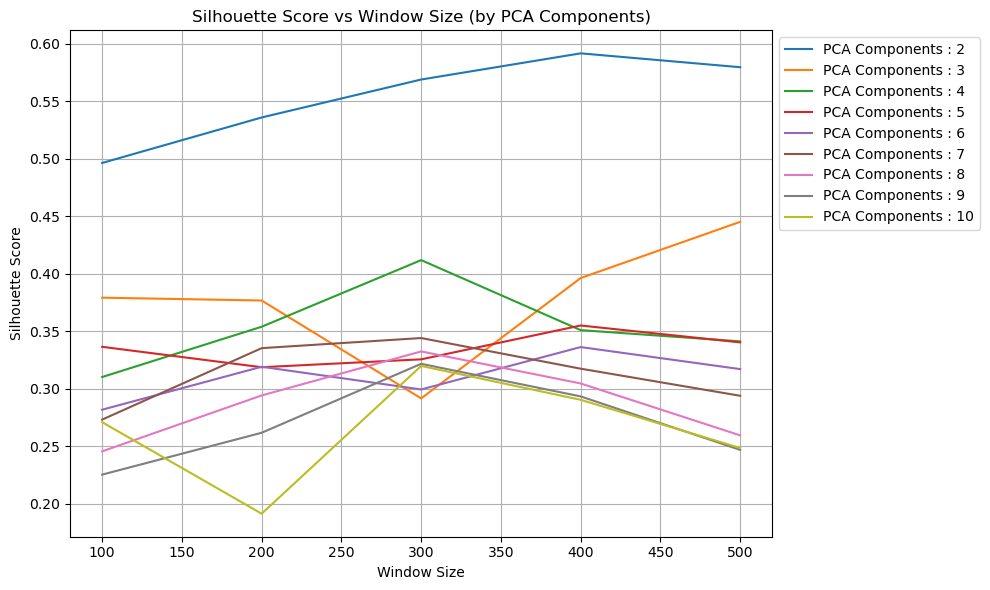

In [20]:
# Retrieve unique PCA component counts used in the silhouette score calculations

unique_pca_components = silhouette_score_df['pca components'].unique()

# Create a figure with specific dimensions

plt.figure(figsize = (10, 6))

# Loop through each unique number of PCA components

for i in unique_pca_components:

    # Filter the dataframe for entries with the current number of PCA components

    pca_data = silhouette_score_df[silhouette_score_df['pca components'] == i]

    # Extract the window sizes and corresponding silhouette scores

    window_size = pca_data['window size']

    silhouette_score = pca_data['silhouette score']

    # Plot the silhouette scores for each window size for the current PCA component setting

    plt.plot(window_size, silhouette_score, label = f'PCA Components : {i}')

# Label the x-axis 

plt.xlabel('Window Size')

# Label the y-axis

plt.ylabel('Silhouette Score')

# Set the title of the plot

plt.title('Silhouette Score vs Window Size (by PCA Components)')

# Add a legend 

plt.legend(bbox_to_anchor=(1.0, 1.0), loc = 'upper left')

# Enable grid lines

plt.grid(True)

# Adjust the layout

plt.tight_layout()

# Display the plot

plt.show()

Interestingly, the best silhouette score (which indicate quality of the clustering) occurred when there are 2 components (PCA 1 and PCA 2) and window size of 400.

#### Clustering at window size 400

In [21]:
 # Create sliding windows of size 400 from the dataframe 'df2'

windows_data = sliding_window(df2, 400)

# Extract features from each windowed segment

extracted_features_list = extract_features(windows_data)

# Convert the list of extracted features into a DataFrame

features_df = pd.DataFrame(extracted_features_list)

C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


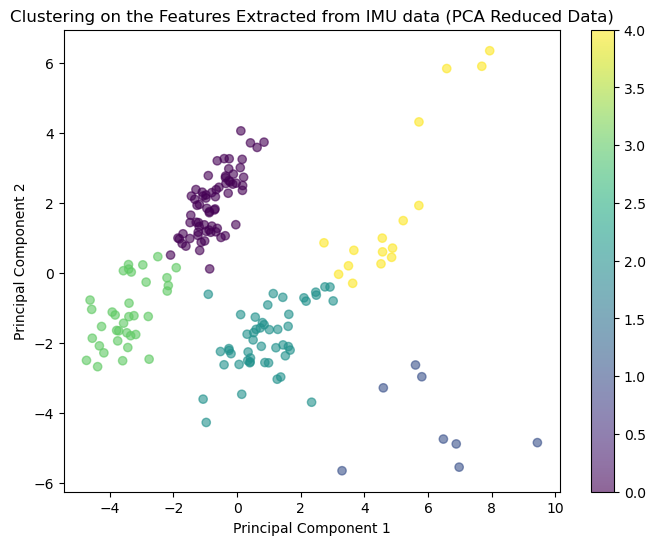

In [22]:
# Remove the 'surface' column from the features DataFrame

data = features_df.drop('surface', axis = 1)

# Scale the data 

data_scaled = StandardScaler().fit_transform(data)

# Initialize PCA with 2 components

pca = PCA(n_components = 2)

# Fit PCA on the scaled data and transform it to get the principal components

principal_components = pca.fit_transform(data_scaled)

# Create a DataFrame for the principal components with column names 'PC1' and 'PC2'

pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

# Initialize KMeans clustering with 5 clusters

kmeans = KMeans(n_clusters = 5, random_state = 42)

# Apply KMeans to the PCA-reduced data

cluster_labels = kmeans.fit_predict(pca_df)

# Create a figure with specific dimensions

plt.figure(figsize=(8, 6))

# Create a scatter plot of the PCA data colored by cluster labels

scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c = cluster_labels, cmap ='viridis', alpha = 0.6)

# Set the title of the plot

plt.title('Clustering on the Features Extracted from IMU data (PCA Reduced Data)')

# Label the x-axis

plt.xlabel('Principal Component 1')

# Label the y-axis

plt.ylabel('Principal Component 2')

# Add a color bar

plt.colorbar(scatter)

# Display the plot

plt.show()

#### Clustering at window size 100

In [23]:
 # Create sliding windows of size 400 from the dataframe 'df2'

windows_data = sliding_window(df2, 100)

# Extract features from each windowed segment

extracted_features_list = extract_features(windows_data)

# Convert the list of extracted features into a DataFrame

features_df = pd.DataFrame(extracted_features_list)

C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


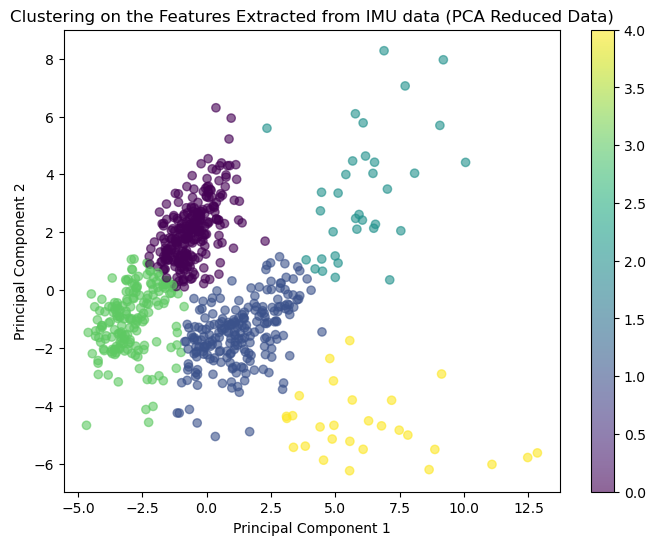

In [24]:
# Remove the 'surface' column from the features DataFrame

data = features_df.drop('surface', axis = 1)

# Scale the data 

data_scaled = StandardScaler().fit_transform(data)

# Initialize PCA with 2 components

pca = PCA(n_components = 2)

# Fit PCA on the scaled data and transform it to get the principal components

principal_components = pca.fit_transform(data_scaled)

# Create a DataFrame for the principal components with column names 'PC1' and 'PC2'

pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

# Initialize KMeans clustering with 5 clusters

kmeans = KMeans(n_clusters = 5, random_state = 42)

# Apply KMeans to the PCA-reduced data

cluster_labels = kmeans.fit_predict(pca_df)

# Create a figure with specific dimensions

plt.figure(figsize=(8, 6))

# Create a scatter plot of the PCA data colored by cluster labels

scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c = cluster_labels, cmap ='viridis', alpha = 0.6)

# Set the title of the plot

plt.title('Clustering on the Features Extracted from IMU data (PCA Reduced Data)')

# Label the x-axis

plt.xlabel('Principal Component 1')

# Label the y-axis

plt.ylabel('Principal Component 2')

# Add a color bar

plt.colorbar(scatter)

# Display the plot

plt.show()

we observe improved clustering quality as window sizes increased